In [1]:
import sys
import warnings
sys.path.append("../../script")

import pandas as pd
import numpy as np
import jenkspy
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

from data_preparation import *
from XGB_utils import *

warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Import et Préparation des données

In [2]:
train = pd.read_csv("../../data/application_train_vf.csv")

In [3]:
dataprep = DataPreparation(train, 0.3)
train_prepared = dataprep.get_prepared_data()

Variables extérieures récupérées ✅
Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


100%|██████████| 10/10 [02:59<00:00, 17.98s/it]


Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 
Variables catégorielles discrétisées ✅


In [4]:
train_prepared["date_mensuelle"] = pd.to_datetime(train_prepared["date_mensuelle"])
train_prepared['date_trimestrielle'] = train_prepared['date_mensuelle'].dt.year.astype(str) + '_' + train_prepared['date_mensuelle'].dt.quarter.astype(str)

# Modélisation

In [5]:
features = ['REGION_RATING_CLIENT_W_CITY', 'DAYS_CREDIT_ENDDATE_disc_int', 'RATE_DOWN_PAYMENT_disc_int', 'AMT_PAYMENT_disc_int', 'NAME_INCOME_TYPE_discret', 'OCCUPATION_TYPE_discret', 'NAME_CONTRACT_TYPE','TARGET']

In [10]:
dic_ref = {
    'REGION_RATING_CLIENT_W_CITY' : "un_deux",
    'DAYS_CREDIT_ENDDATE_disc_int' : "[-155271.0;-58.0]",
    'RATE_DOWN_PAYMENT_disc_int' : "[0.2;4.48]",
    'AMT_PAYMENT_disc_int' : "[143996.31;25537053.78]",
    'NAME_INCOME_TYPE_discret' : "Low_income",
    'OCCUPATION_TYPE_discret' : "high_skilled",
    'NAME_CONTRACT_TYPE' : "Revolving_loans"
}

In [ ]:
model = XGB_model(train_prepared[features], dic_ref)
shap_df = model.run_xgb_model()

In [12]:
shap_df

,Coefficient,Variable,Modality
0,-0.065586,REGION_RATING_CLIENT_W_CITY,un_deux_ref
1,0.337861,REGION_RATING_CLIENT_W_CITY,trois
2,-0.257586,DAYS_CREDIT_ENDDATE_disc_int,[-155271.0;-58.0]_ref
3,0.189267,DAYS_CREDIT_ENDDATE_disc_int,[-57.0;214193.0]
4,-0.173421,RATE_DOWN_PAYMENT_disc_int,[0.2;4.48]_ref
5,0.076118,RATE_DOWN_PAYMENT_disc_int,[-0.0;0.2]
6,-0.068553,AMT_PAYMENT_disc_int,[143996.31;25537053.78]_ref
7,0.134964,AMT_PAYMENT_disc_int,[0.0;143993.84]
8,-0.372695,NAME_INCOME_TYPE_discret,Low_income_ref
9,0.101500,NAME_INCOME_TYPE_discret,high_income


# Grille de Score

In [13]:
gs = GridScoreXGB(train_prepared, shap_df)
grid_score = gs.compute_grid_score()

In [14]:
grid_score

,Variable,Modality,Coefficient,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,REGION_RATING_CLIENT_W_CITY,un_deux_ref,-0.065586,154.110649,15.0,6.13,85.76
1,REGION_RATING_CLIENT_W_CITY,trois,0.337861,0.000000,15.0,1.55,14.24
2,DAYS_CREDIT_ENDDATE_disc_int,[-155271.0;-58.0]_ref,-0.257586,170.691057,17.0,2.75,47.02
3,DAYS_CREDIT_ENDDATE_disc_int,[-57.0;214193.0],0.189267,0.000000,17.0,4.92,52.98
4,RATE_DOWN_PAYMENT_disc_int,[0.2;4.48]_ref,-0.173421,95.320259,10.0,2.07,33.15
5,RATE_DOWN_PAYMENT_disc_int,[-0.0;0.2],0.076118,0.000000,10.0,5.60,66.85
6,AMT_PAYMENT_disc_int,[143996.31;25537053.78]_ref,-0.068553,77.740699,8.0,4.86,68.72
7,AMT_PAYMENT_disc_int,[0.0;143993.84],0.134964,0.000000,8.0,2.81,31.28
8,NAME_INCOME_TYPE_discret,Low_income_ref,-0.372695,181.135464,18.0,1.31,25.11
9,NAME_INCOME_TYPE_discret,high_income,0.101500,0.000000,18.0,6.36,74.89


In [15]:
df_score = gs.get_individual_score()

# Segmentation

In [16]:
scores_clients = df_score["Score_ind"]
nombre_de_classes = 6 

breaks = jenkspy.jenks_breaks(scores_clients, nombre_de_classes)
print(breaks)

[0.0, 181.13546405910827, 282.48146261523385, 368.2966680997793, 475.1125212776718, 607.2831685973806, 1000.0]


In [28]:
breaks = [0.0, 181, 282, 348, 425, 580, 680]

df_score["Classes"] = np.digitize(df_score["Score_ind"], bins=sorted(breaks))

resultats = df_score.groupby("Classes").agg(
    moyenne_TARGET=("TARGET", "mean"),
    nb_individus=("TARGET", "size")
)
resultats['taux_individus'] = (resultats['nb_individus'] / df_score.shape[0]) * 100

print(resultats)

         moyenne_TARGET  nb_individus  taux_individus
Classes                                              
1              0.141903         32952       10.764863
2              0.108562         47125       15.394944
3              0.082728         50696       16.561529
4              0.070028         59862       19.555907
5              0.051951         69565       22.725714
6              0.038601         36139       11.806002
7              0.030303          9768        3.191041


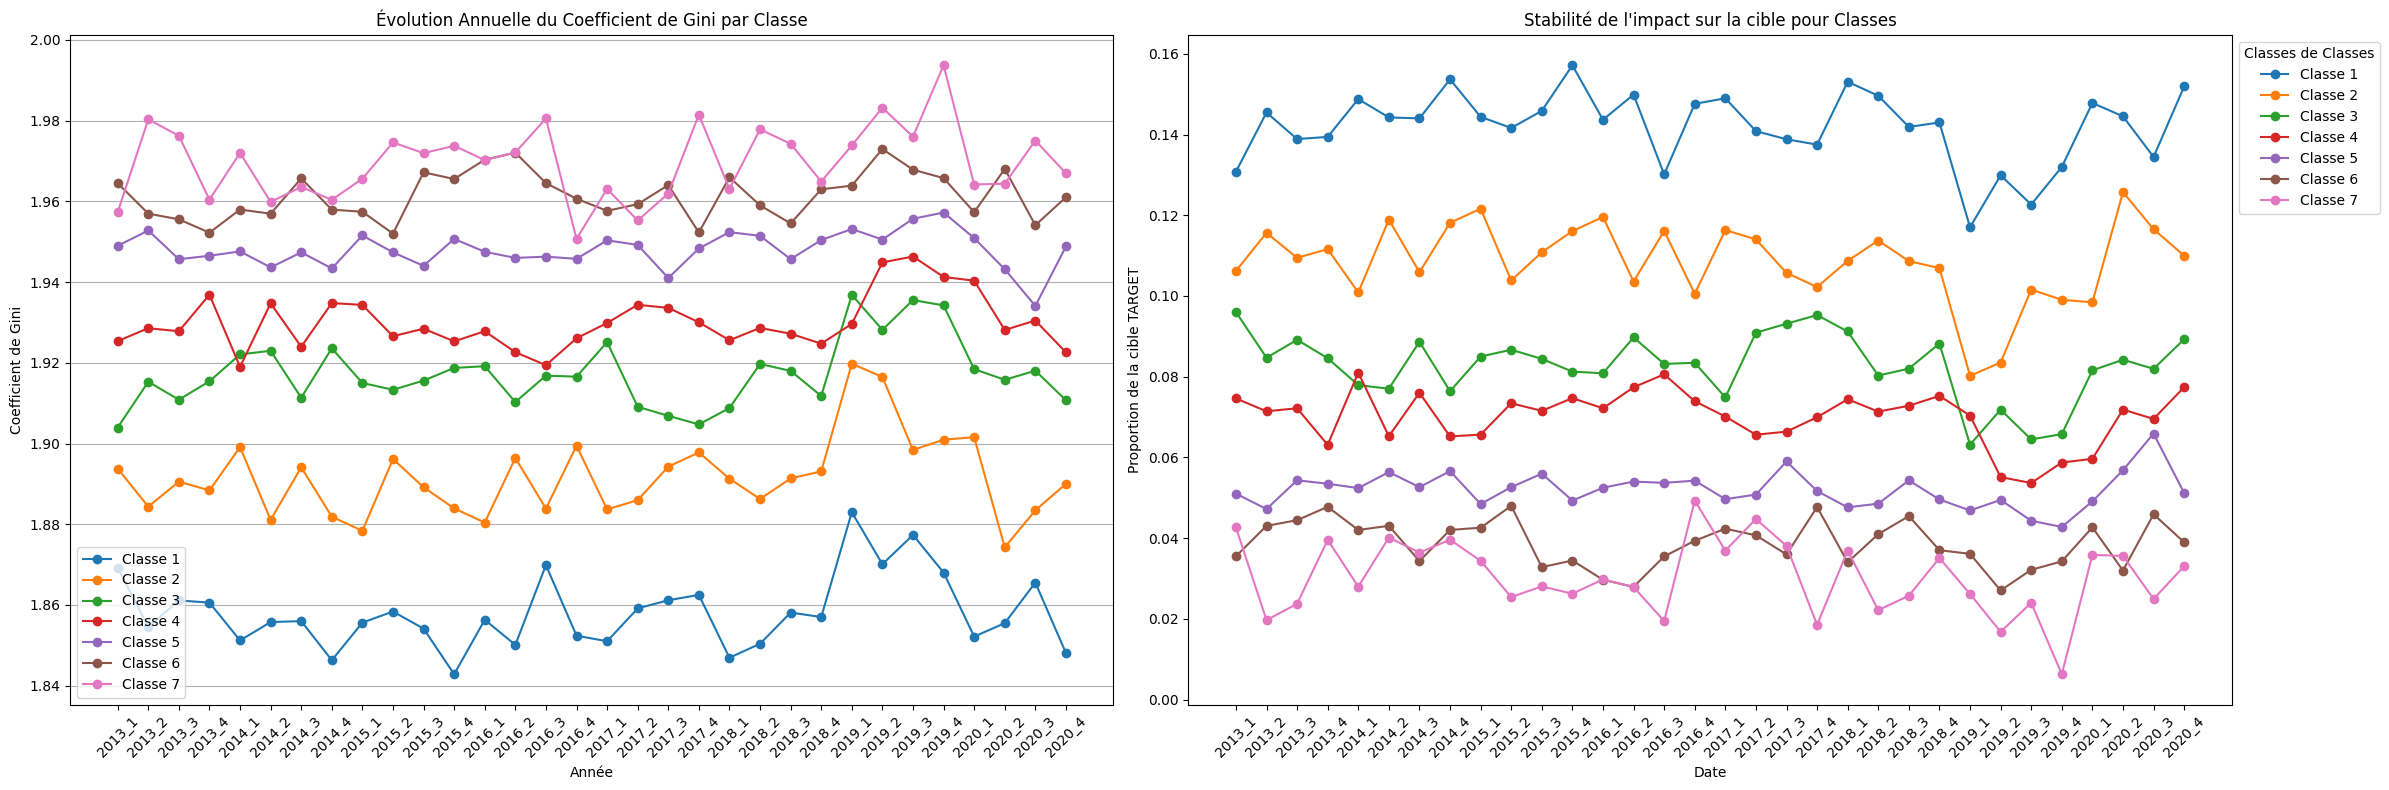

In [29]:
def gini_coefficient(values):
    sorted_values = np.sort(values)
    n = len(values)
    cumulative_values_sum = np.cumsum(sorted_values)
    gini_index = (2 * np.sum(cumulative_values_sum) / (n * np.sum(sorted_values))) - (n + 1) / n
    return 1 - gini_index

fig, axes = plt.subplots(1, 2, figsize=(24, 8)) 

for classe in range(1, 8): 
    df_classe = df_score[df_score['Classes'] == classe][["date_trimestrielle", "TARGET"]]
    grouped = df_classe.groupby(df_classe['date_trimestrielle'])["TARGET"]
    gini_per_year = grouped.apply(gini_coefficient)
    
    axes[0].plot(gini_per_year.index, gini_per_year, label=f'Classe {classe}', marker='o')

axes[0].set_title('Évolution Annuelle du Coefficient de Gini par Classe')
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Coefficient de Gini')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

def plot_stability_taux(ax, train, variable):
    stability_df = train.groupby(['date_trimestrielle', variable])['TARGET'].mean().unstack()
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        ax.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    ax.set_title(f'Stabilité de l\'impact sur la cible pour {variable}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Proportion de la cible TARGET')
    ax.legend(title=f'Classes de {variable}', loc='upper left', bbox_to_anchor=(1, 1))
    ax.tick_params(axis='x', rotation=45)

plot_stability_taux(axes[1], df_score, 'Classes')

plt.tight_layout()
plt.show()